# Dataset analysis
To generate results for every dataset in the `dataset` folder, run:
```
for dataset in $(find dataset/* -maxdepth 0 -type d); do papermill dataset-info/DatasetBase.ipynb dataset-info/$(basename $dataset).ipynb -p input_dir $dataset; done
```

In [1]:
import matplotlib.pyplot as plt
import re, os
import papermill as pm
%matplotlib inline

In [2]:
# Parameters
input_dir = "dataset/hospitalrun-frontend"


In [3]:
# Make a regex to extract dataset name
import re

matchObj = re.match( r'.*/(.*)', input_dir, re.M|re.I)
if matchObj:
    dataset_id = matchObj.group(1)
    dataset_id

In [4]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [5]:
# List files in input_dir in natural order
files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]
files = natural_sort(files)
files[0:5]

['dataset/hospitalrun-frontend/2014_03_28_1b66f474e547b4c31869a4eb22b9956a25d000fb.csv',
 'dataset/hospitalrun-frontend/2014_04_30_e4d3eaacd3a76229c58226ba0a7571f9c96ef5ec.csv',
 'dataset/hospitalrun-frontend/2014_05_30_7d279dcf926d0624bc63b4efabc863f43024006e.csv',
 'dataset/hospitalrun-frontend/2014_06_20_7012051cc3c058c7b33a9938ee1524f1be3095e5.csv',
 'dataset/hospitalrun-frontend/2014_07_31_99b8bd78e7bf48565ac3d39994802024df391f58.csv']

In [6]:
import pandas as pd
n_revisions = len(files)
dfs = [pd.read_csv(file) for file in files]

In [7]:
dfs[0].head()

,id,weight
0,ndor/ember/ember.js,43100
1,ndor/ember/ember.prod.js,41525
2,ndor/jquery/jquery.js,9597
3,ndor/pouchdb-nightly.js/index.js,7569
4,ndor/jquery/speed/jquery-basis.js,6238


In [8]:
from functools import reduce
# Outer join of files  
df_full = reduce((lambda x, y: pd.merge(x, y, how='outer', on='id')), dfs)

In [9]:
# Rename columns
df_full.columns = ['id'] + ['t'+str(i) for i in range(df_full.shape[1]-1)]

In [10]:
df_full.head()

,id,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,t28,t29,t30,t31,t32,t33,t34,t35,t36,t37
0,ndor/ember/ember.js,43100.0,44267.0,44267.0,44267.0,44267.0,44267.0,44267.0,46762.0,46762.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ndor/ember/ember.prod.js,41525.0,42649.0,42649.0,42649.0,42649.0,42649.0,42649.0,46319.0,46319.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ndor/jquery/jquery.js,9597.0,9597.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ndor/pouchdb-nightly.js/index.js,7569.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ndor/jquery/speed/jquery-basis.js,6238.0,6238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
from collections import defaultdict
import networkx as nx

FILE_MARKER = '<files>'

def attach(branch, trunk):
    parts = branch.split('/', 1)
    if len(parts) == 1:  # branch is a file
        trunk[FILE_MARKER].append(parts[0])
    else:
        node, others = parts
        if node not in trunk:
            trunk[node] = defaultdict(dict, ((FILE_MARKER, []),))
        attach(others, trunk[node])

def build_adjacency_list(d, id, result):
    for key in d.keys():
        if key != FILE_MARKER:
            result.append((id, id + key))
            build_adjacency_list(d[key], id + key, result)
        else:
            for file in d[key]:
                result.append((id, id + file))

        
def plot_tree(id_list):
    
    keys = sorted(id_list)

    main_dict = defaultdict(dict, ((FILE_MARKER, []),))
    for line in keys:
        attach(line, main_dict)

    # _create adjacency list
    result = []
    build_adjacency_list(main_dict, "ROOT", result)

    G = nx.DiGraph()
    G.add_edges_from(result)
    # write dot file to use with graphviz
    # run "dot -_tpng test.dot >test.png"
    # nx.nx_agraph.write_dot(_g, 'test.dot')

    # same layout using matplotlib with no labels
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=False, arrows=False, node_size=2)



## Union tree of all revisions

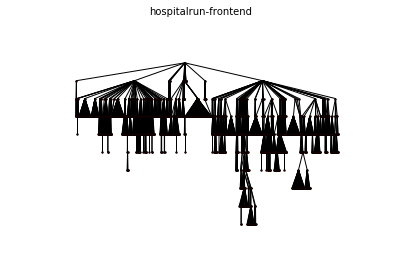

In [12]:
tree_fig = plt.figure(0)
tree_fig.suptitle(dataset_id)
plt.axis('off')
plot_tree(df_full['id'].tolist())
#pm.display('tree', tree_fig)



# Evolution

## Items count

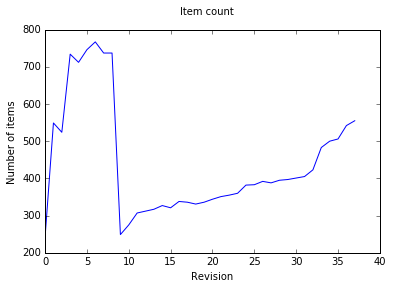

In [13]:
def plot_item_count():
    n_items = [len(df) for df in dfs]
    plt.plot(n_items)

fig = plt.figure()
fig.suptitle("Item count")
plt.ylabel('Number of items')
plt.xlabel('Revision')

plot_item_count()

## Weight count

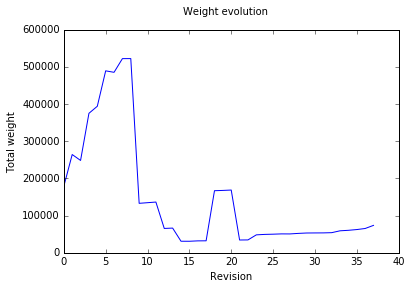

In [14]:
def plot_weight():
    total_weight = [sum(df['weight']) for df in dfs]
    plt.plot(total_weight)

fig = plt.figure()
fig.suptitle("Weight evolution")
plt.ylabel('Total weight')
plt.xlabel('Revision')
plot_weight()

## Addition and removal of items

In [15]:
# How to find removals
pd.merge(dfs[0], dfs[1], on='id', how='outer', indicator=True).query('_merge=="left_only"')

,id,weight_x,weight_y,_merge
3,ndor/pouchdb-nightly.js/index.js,7569.0,NaN,left_only
37,ndor/FakeXMLHttpRequest/fake_xml_http_request.js,473.0,NaN,left_only
68,sts/helpers/module_for.js,143.0,NaN,left_only
79,ndor/ic-ajax/main.js,126.0,NaN,left_only
82,ndor/FakeXMLHttpRequest/test/unsafe_headers_te...,81.0,NaN,left_only
88,ndor/FakeXMLHttpRequest/test/open_test.js,72.0,NaN,left_only
95,ndor/FakeXMLHttpRequest/test/aborting_test.js,56.0,NaN,left_only
96,ndor/loader.js,56.0,NaN,left_only
98,ndor/fakehr/fakehr.js,62.0,NaN,left_only
99,ndor/FakeXMLHttpRequest/test/responding_test.js,51.0,NaN,left_only


In [16]:
# How to find additions
pd.merge(dfs[0], dfs[1], on='id', how='outer', indicator=True).query('_merge=="right_only"')
# len(pd.merge...) to get the number of additions/deletions

,id,weight_x,weight_y,_merge
242,ndor/pouchdb/dist/pouchdb-nightly.js,NaN,8063.0,right_only
243,ndor/pouchdb/tests/deps/pouchdb-2.0.0-postfixe...,NaN,7569.0,right_only
244,ndor/bootstrap/dist/css/bootstrap.css,NaN,5785.0,right_only
245,ndor/pouchdb/tests/deps/pouchdb-1.1.0-postfixe...,NaN,5892.0,right_only
246,ndor/pouchdb/vendor/bluebird.js,NaN,5059.0,right_only
247,ndor/oauth-signature-js/src/lib-dev/mocha/moch...,NaN,5812.0,right_only
248,ndor/oauth-signature-js/src/lib-dev/chai/chai.js,NaN,4696.0,right_only
249,ndor/oauth-signature-js/src/lib-dev/qunit/quni...,NaN,2288.0,right_only
250,ndor/pouchdb/tests/test.replication.js,NaN,1586.0,right_only
251,ndor/bootstrap/dist/js/bootstrap.js,NaN,1951.0,right_only


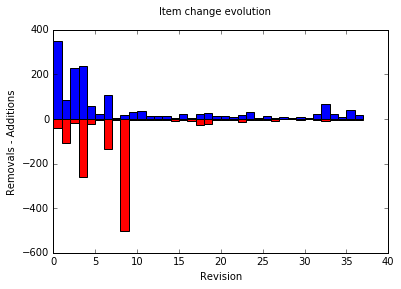

In [17]:
fig, ax = plt.subplots()

n_additions = []
n_removals = []
for i in range(1, n_revisions):
    n_additions.append(
        len(pd.merge(dfs[i-1], dfs[i], on='id', how='outer', indicator=True)
            .query('_merge=="right_only"')))
    n_removals.append(
        -len(pd.merge(dfs[i-1], dfs[i], on='id', how='outer', indicator=True)
            .query('_merge=="left_only"')))
x = range(0, n_revisions - 1)
ax.bar(x ,n_additions, width=1, color='b')
ax.bar(x, n_removals, width=1, color='r')

fig.suptitle("Item change evolution")
plt.ylabel('Removals - Additions')
plt.xlabel('Revision')



## Sum of cell's change in weight (stability)

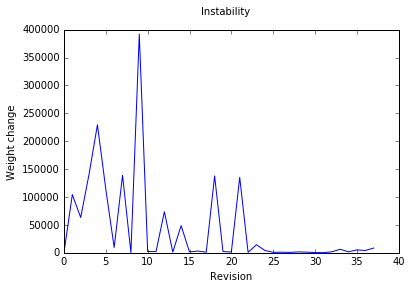

In [18]:
fig = plt.figure()
change = [0.0] * n_revisions
for index, row in df_full.fillna(0).iterrows():
    for j in range (2, len(row)):
        change[j-1] += abs(row[j] - row[j-1])

plt.plot(change)
fig.suptitle("Instability")
plt.ylabel('Weight change')
plt.xlabel('Revision')
    